# Comparacion de algoritmos


Este ejemplo muestra características de diferentes algoritmos altamente citados en la comunidad de Machine Learning. Los datasets usados son sintéticos y bidimensionales, creados para poder visualizar mejor las particularidades de los algoritmos.
Se ha tratado de mostrar buenos parámetros, para poder mostrar agrupamientos competitivos.

El último dataset es una nube aleatoria, no debería haber mas de un cluster. Los algortimos automáticos funcionan mejor que los que tienen asignados en forma fija el número de clusters.

Este ejemplo puede ser modificado para presentar sobre estos grupos de datos, salidas de un mismo algoritmo para distintos parámetros.

La base de esta notebook fue obtenida de sklearn.

Automatically created module for IPython interactive environment


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packa

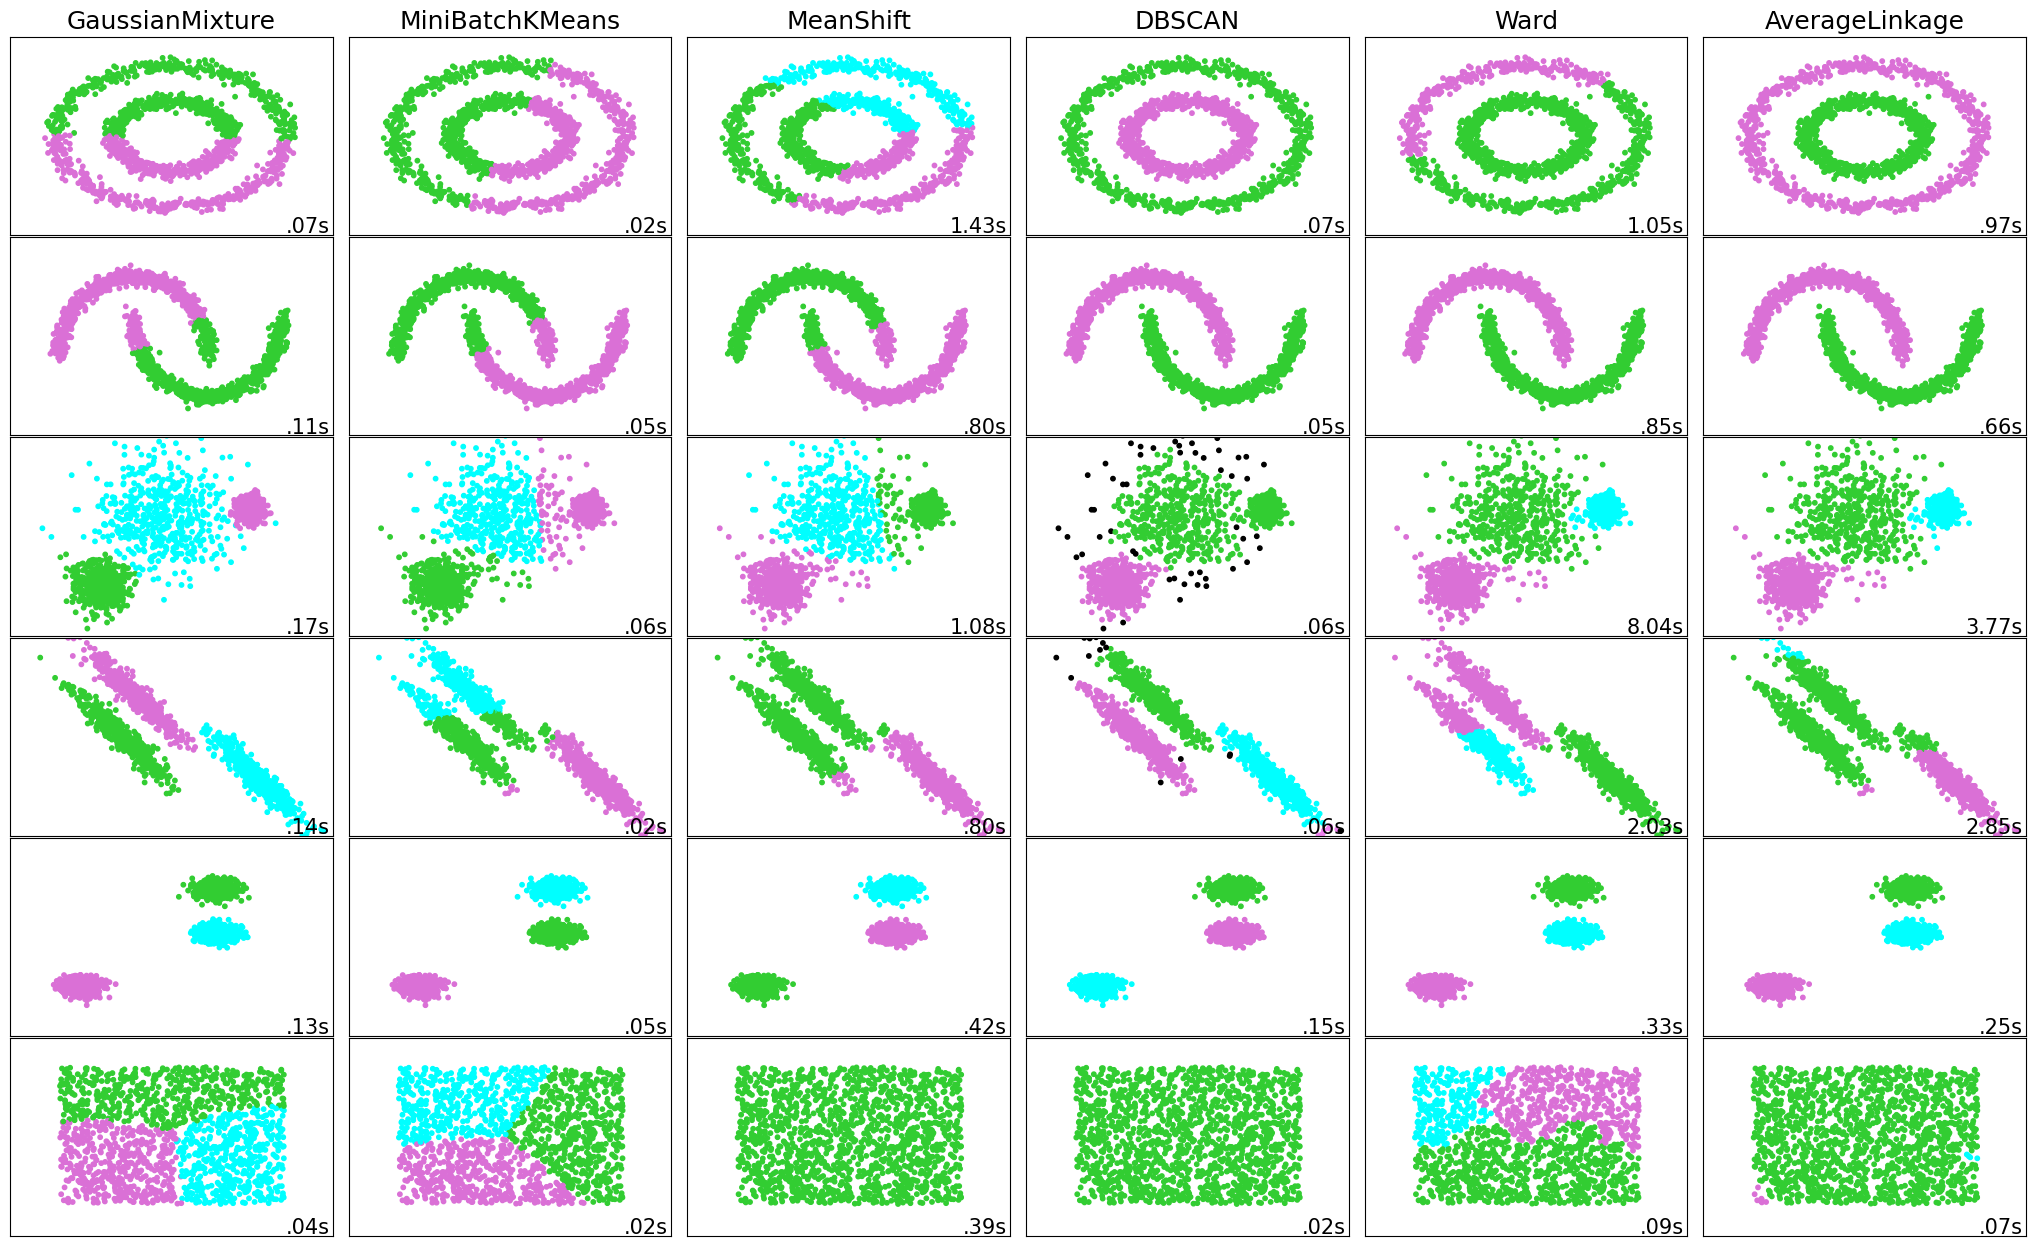

In [ ]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generar datasets, Se elige un numero de datos suficientemente grande para tener caracteristicas interesantes
#sin tener problemas de escala y tiempo de procesamiento
#puede cambiarse
#==========

n_samples = 1500
random_state = 170
#----------
#circulos concentricos con ruido (diana para tirar dardos)
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

# dos medias lunas, problematico para agrupamientos por distancia euclidea.
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

# circulos con distintas varianzas por lo cual estan cerquita y pueden tener tambien diferente tamaño de muestra
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# circulos separados, dataset en el cual todo algoritmo deberia andar bien

blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# ruido aleatorio, un solo cluster.
no_structure = np.random.rand(n_samples, 2), None

# datos distribuidos anisotroppicamente, esto es, como granos de arroz y cerquita
random_state = 170

X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)



# ============
# parametros de figura
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
# ============
#Parmetros usuales de algoritmos
# ============
plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}
# ============
# parametros especificos de cada datasets (para que les vaya mejor)
#============
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

# ============
# Armado de figura
# ============
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # actualizacion de parametros de cada dataset
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalizacion de datos (zscore)
    X = StandardScaler().fit_transform(X)

    # estimacion de bandwidth para mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectividad para mejor algoritmos de arboles
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)

    # conectividad simetrica
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Crear objetos cluster
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])

    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward',connectivity=connectivity)

    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',affinity="nearest_neighbors")

    dbscan = cluster.DBSCAN(eps=params['eps'])
    #optics = cluster.OPTICS(min_samples=params['min_samples'],xi=params['xi'],min_cluster_size=params['min_cluster_size'])
    #affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])

    average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",n_clusters=params['n_clusters'], connectivity=connectivity)

    #birch = cluster.Birch(n_clusters=params['n_clusters'])

    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('GaussianMixture', gmm),
        ('MiniBatchKMeans', two_means),
        ('MeanShift', ms),
        ('DBSCAN', dbscan),
        ('Ward', ward),
        ('AverageLinkage', average_linkage))
        #('SpectralClustering', spectral),
        #('OPTICS', optics),
        #('Birch', birch),
        #('AffinityPropagation', affinity_propagation),
        #)

    # armado de la fila de la figura, es decir, un dataset, 6 metodos

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        #colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             #'#f781bf', '#a65628', '#984ea3',
                                             #'#999999', '#e41a1c', '#dede00']),
                                      #int(max(y_pred) + 1))))
        colors = np.array(list(islice(cycle(['limegreen', 'orchid', 'aqua',
                                             'violet', 'magenta', 'deeppink',
                                             'crimson', 'fuchsia', 'blue']),
                                      int(max(y_pred) + 1))))

        # add black color for outliers (if any)

        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
#plt.savefig('metodos.png', dpi=300)
plt.show()

# Elipsoides sobre el ajuste de mezcla de gaussianas.

Ploteamos los elipsoides de confianza calculados por Expectation Maximisation (GaussianMixture class) ajustados a datos simulados con una mezcla de dos Gaussianas.

- El modelo Expectation Maximization va a usar necesariamente k componentes prefijadas.

- Aqui podemos ver que el modelo Expectation Maximisation depende del numero correcto de gaussianas en la Mezcla. Si le decimos que k=2, encuentra las Gaussianas.

- Si le decimos que k=3 o k=5, el ajuste parte los datos en los clusters necesarios para ajustarse a ese dato

-  Para calcular esta figura realizamos el siguiente codigo:

    - Cargamos el modulo mixture de sklearn
    - definimos los colores con los que vamos a marcar los datos aprendidos.

In [ ]:
%matplotlib inline
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['limegreen', 'orchid', 'aqua','violet', 'magenta', 'deeppink','crimson', 'fuchsia', 'blue'])




- Esta funcion va a armar un elipsoide de confianza usando los ejes de la matriz de covarianza estimada para la mezcla
- Arma los paneles de la figura

In [ ]:
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(3, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


- Aqui simulamos 500 muestras de dos componentes normales mezcladas

In [ ]:

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

- Se calculan los parámetros de la mezcla y se plotean de acuerdo a la prediccion de etiqueta que hace el mismo método.

<ipython-input-4-dd0e9556c34c>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-4-dd0e9556c34c>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-4-dd0e9556c34c>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)


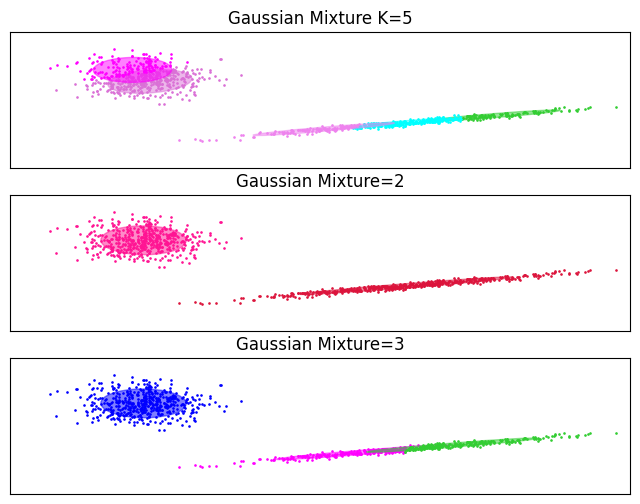

In [ ]:
# Fit a Gaussian mixture with EM using five components
gmm2 = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plt.figure(figsize=(8,6))
plot_results(X, gmm2.predict(X), gmm2.means_, gmm2.covariances_, 0,'Gaussian Mixture K=5')

# Fit a Dirichlet process Gaussian mixture using five components
#dpgmm = mixture.BayesianGaussianMixture(n_components=5,covariance_type='full').fit(X)

#plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 0,'Bayesian Gaussian Mixture')


# Fit a Gaussian mixture with EM using 2 components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 1,'Gaussian Mixture=2')

# Fit a Gaussian mixture with EM using 3 components
gmm1 = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(X)
plot_results(X, gmm1.predict(X), gmm1.means_, gmm1.covariances_, 2,'Gaussian Mixture=3')


#plt.savefig('gaussian_mixtureK', dpi=300)
plt.show()

# Selección de modelo de Mezcla de gaussianas

En este ejemplo se muestra como usar BIC para seleccionar el modelo completo, el numero de elementos de la mezcla y el tipo de matriz de covarianza.

Automatically created module for IPython interactive environment


<ipython-input-7-80d10c20d8ad>:74: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)


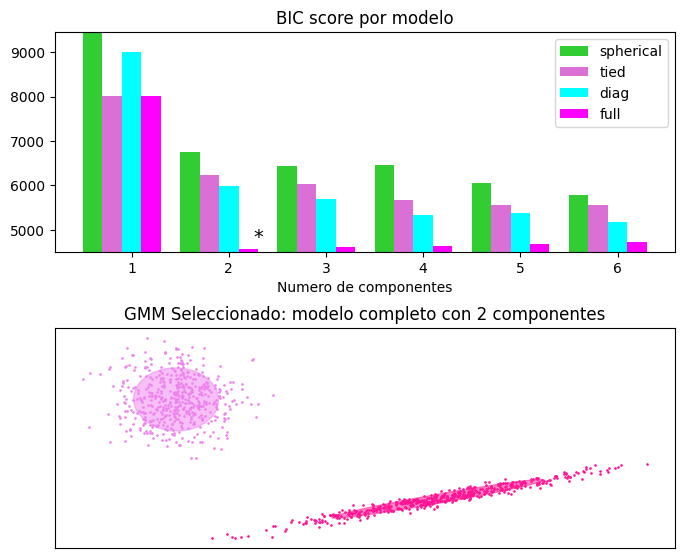

In [ ]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['limegreen', 'orchid', 'aqua',
                                              'magenta','violet', 'deeppink',
                                             'crimson', 'fuchsia', 'blue'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score por modelo')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Numero de componentes')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('GMM Seleccionado: modelo completo con 2 componentes')
plt.subplots_adjust(hspace=.35, bottom=.02)
#plt.savefig('gaussian_mixture3', dpi=300)
plt.show()

# K medias sobre datasets simulados con diferentes gaussianas


K medias es optimo para determinar agrupamientos dprovenientes de Gaussianas esfericas.

Si los datos fueron generdos por gausianas anisotropicas o muy cercanas, K medias no logra diferenciar correctamente los grupos.

El problema de grupos muy cercanos lo tienen todos los métodos.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-8-21a712d76c87>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._ch

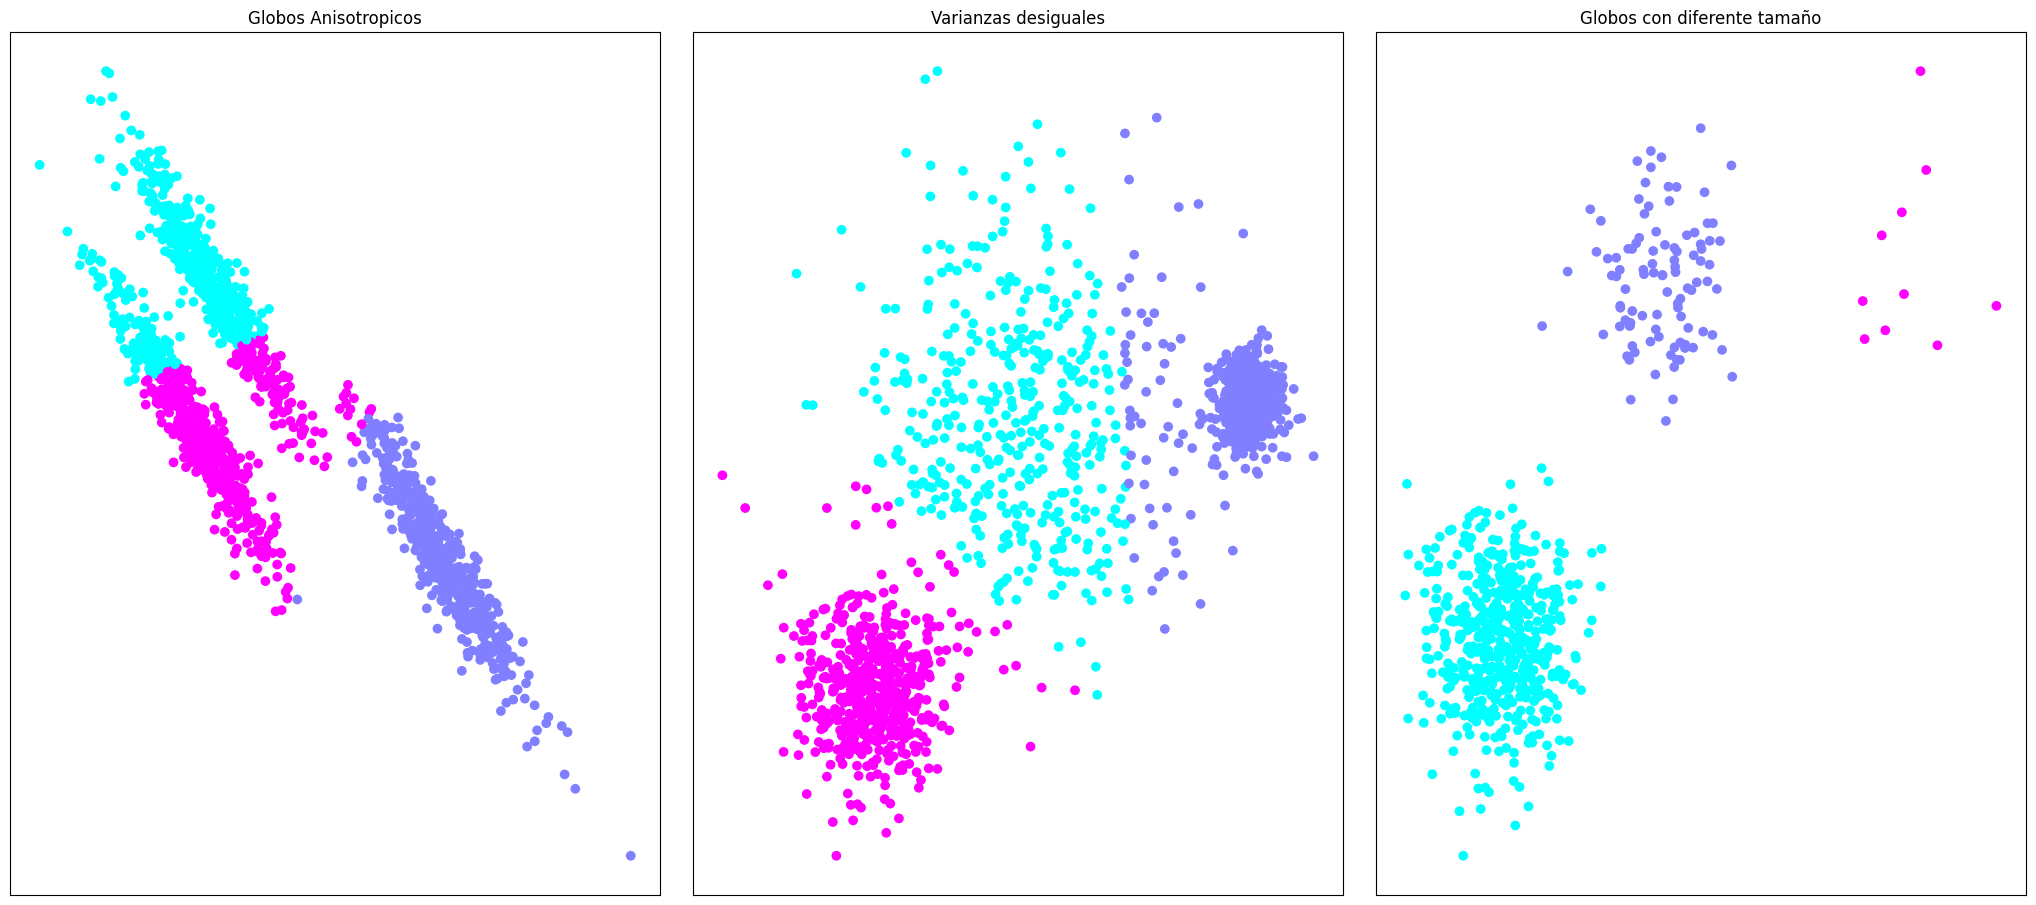

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(9 * 2 + 3, 9))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plt.set_cmap('cool')
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)
plt.xticks(())
plt.yticks(())
plt.subplot(131)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Globos Anisotropicos")
plt.xticks(())
plt.yticks(())

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(132)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Varianzas desiguales")
plt.xticks(())
plt.yticks(())

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(133)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Globos con diferente tamaño")

plt.xticks(())
plt.yticks(())
#plt.savefig('kmeans2.png', dpi=300)
plt.show()

# Veamos como seleccionar el valor de k de kmedias con silhouette analysis

No podemos usar BIC, o MDL o AIC porque no usamos un modelo de verosimilitud para ajustar. Pero si podemos comparar entre diferentes modelos en función de k el valor de la inercia del modelo, esto es, la suma de distancias cuadradas dentro de cada cluster de la partición final.

La inercia se considera una medida de cuán coherentes los clusters son por lo cual si se hace un gráfico de la inercia en función del k, se considera heurísticamente que el mejor valor se da cuando se desacelera la reducción de la inercia. Esto se llama ''metodo del codo''.

Otra forma es considerar el coeficiente de silueta, que tiene valor entre -1 y 1. Los coeficientes s(i) cercanos a +1 indican que la muestra está lejos de los clusters vecinos. El valor 0 indica que la muestra está muy cerca del borde de decisión entre los clusters. Un valor negativo indica que esos puntos deben haber sido asignados al cluster equivocado.

El gráfico de esos coeficientes muestra tambien el balance de los clusters. Si un cluster tiene muchos datos con reespecto a otro que tiene muy pocos datos, o cuyos valores son meonres al valor medio de los coeficientes, indican que ese agrupamiento no es bueno.

En los sigueintes gráficos se ven los agrupamientos para k dede 2 a 6, y el gráfico de la inercia. Tanto el coeficiente medio de silueta como la inercia marcan el k como 4, el cual es el verdadero agrupamiento.

Automatically created module for IPython interactive environment
Para n_clusters = 2 El silhouette_score promedio es : 0.7049787496083262


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para n_clusters = 3 El silhouette_score promedio es : 0.5882004012129721
Para n_clusters = 4 El silhouette_score promedio es : 0.6505186632729437


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Para n_clusters = 5 El silhouette_score promedio es : 0.5804620679044765
Para n_clusters = 6 El silhouette_score promedio es : 0.4966479110816958


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


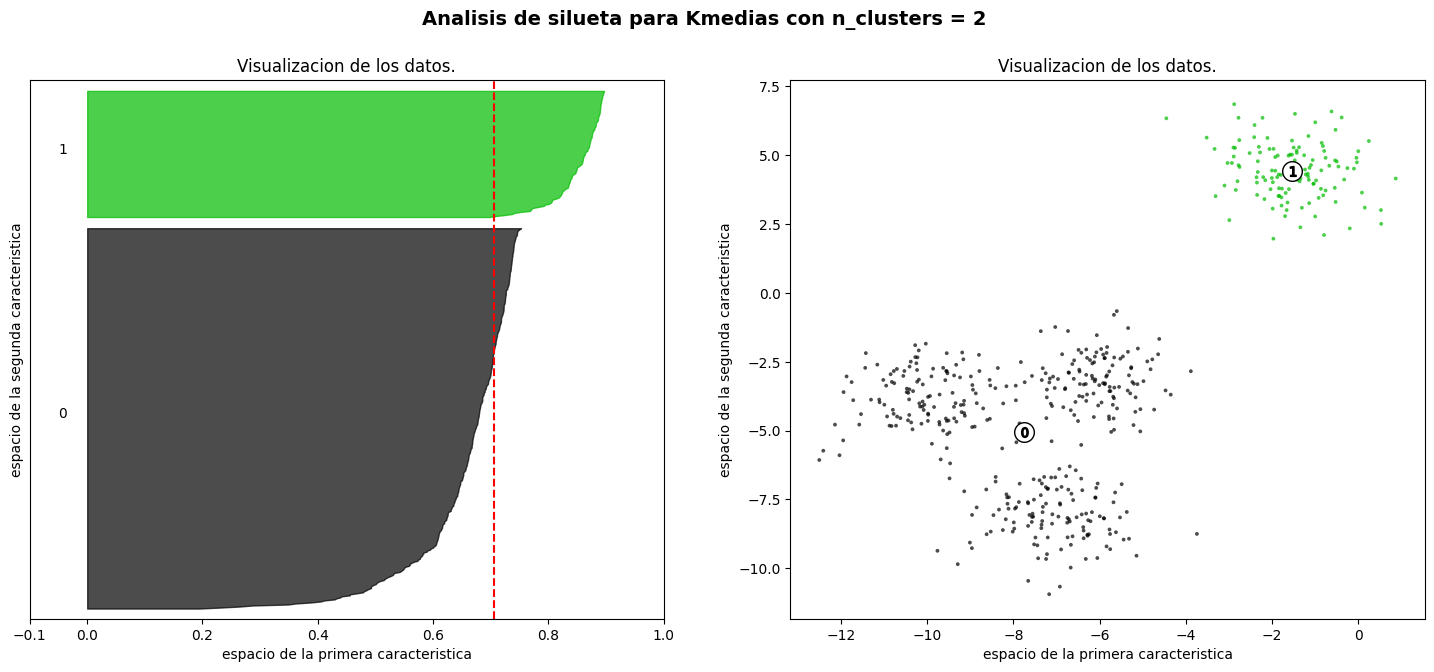

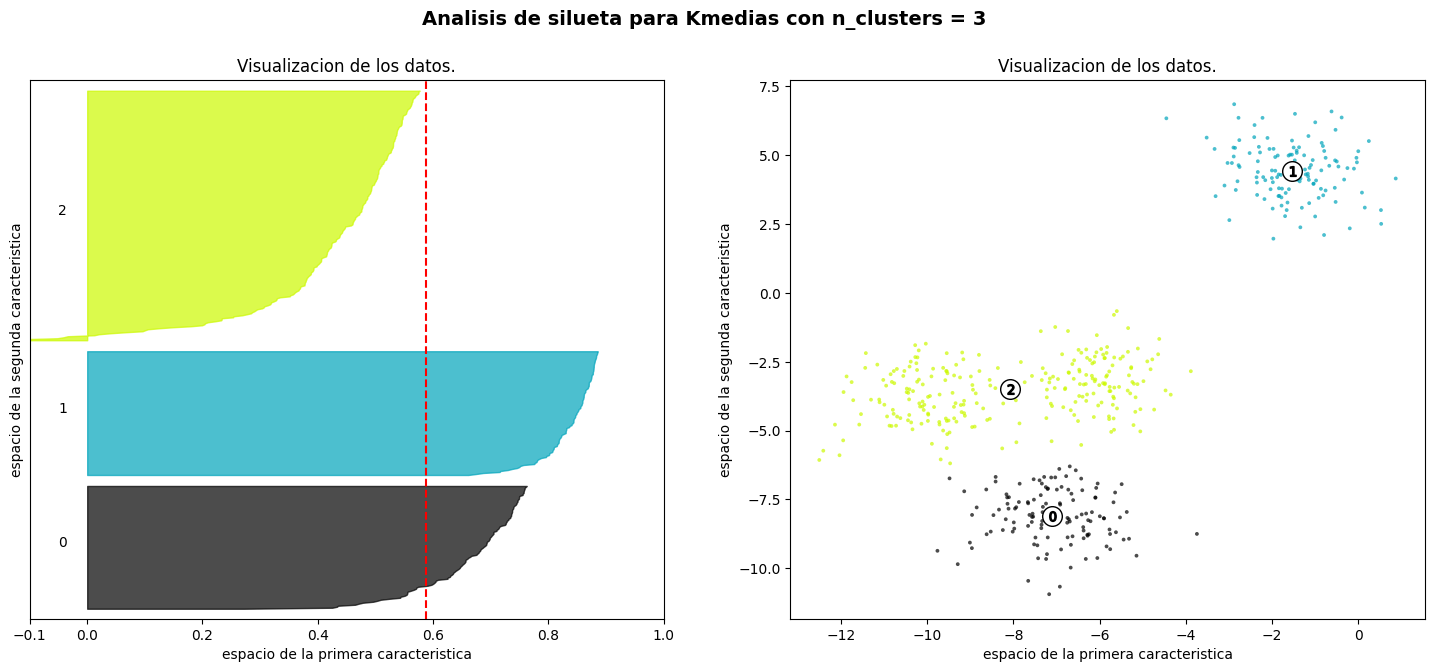

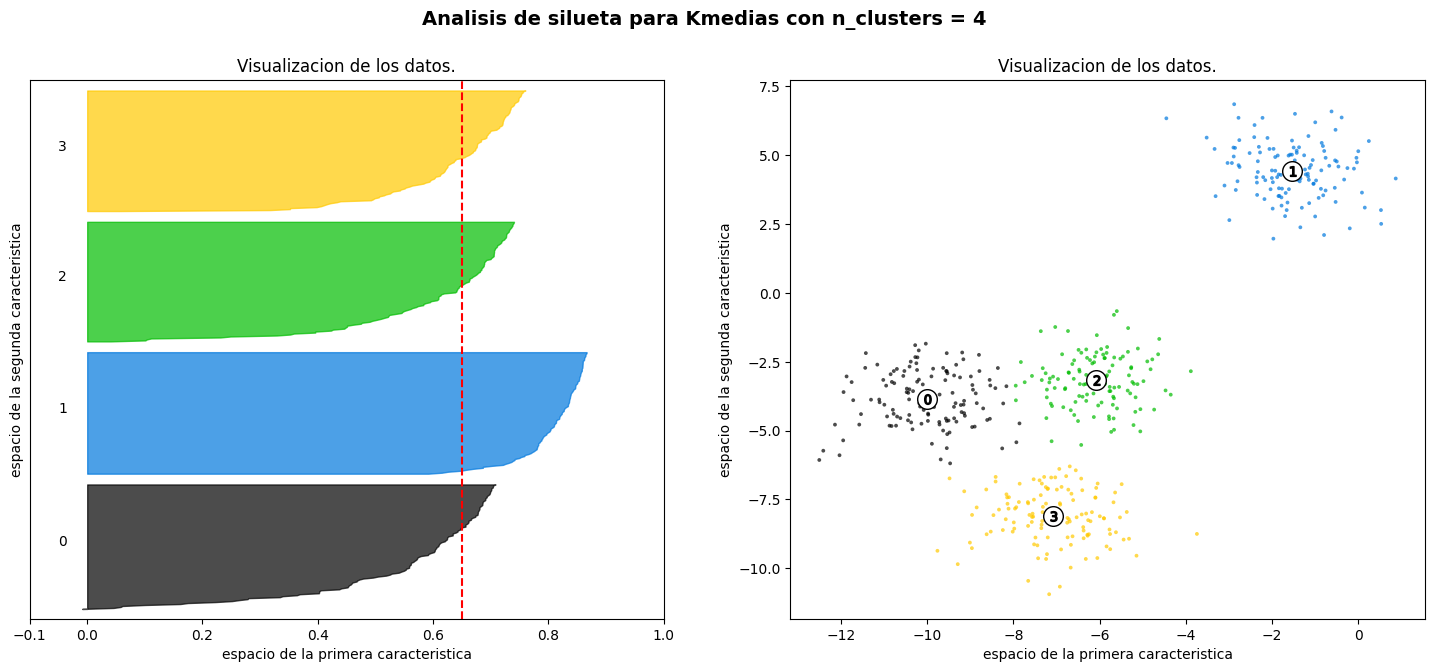

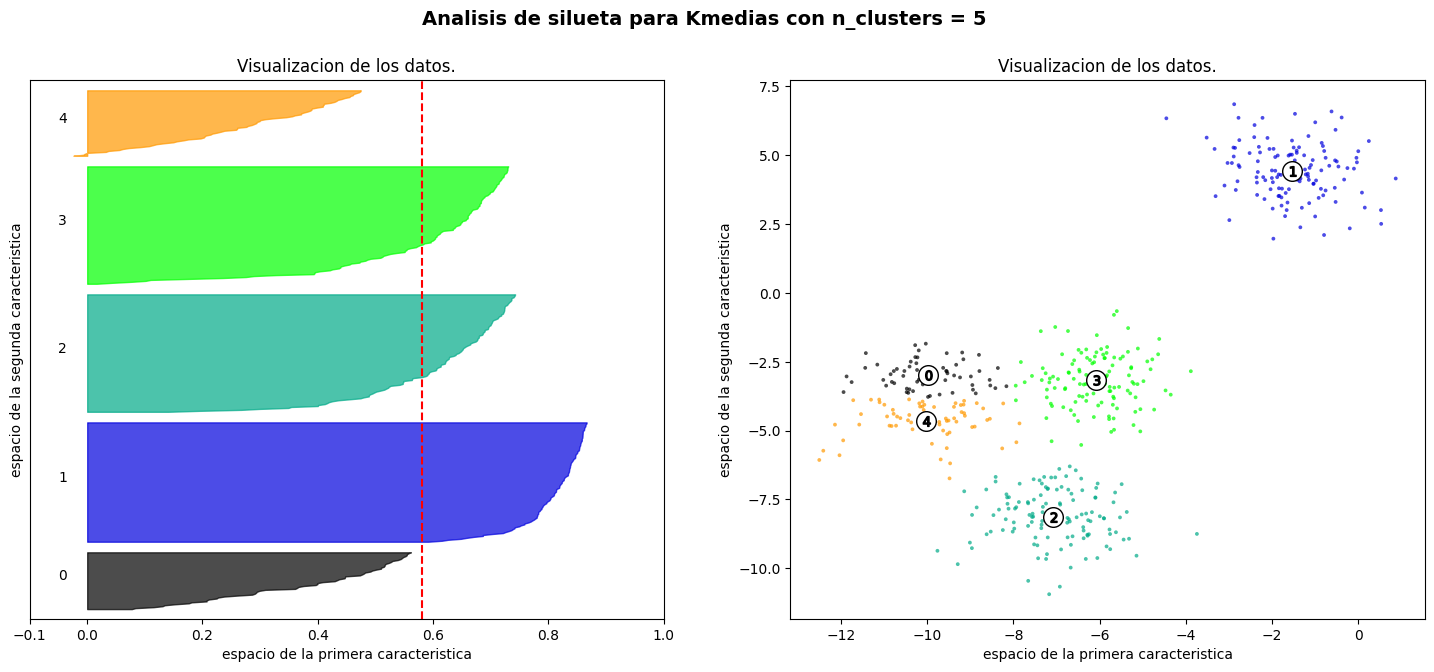

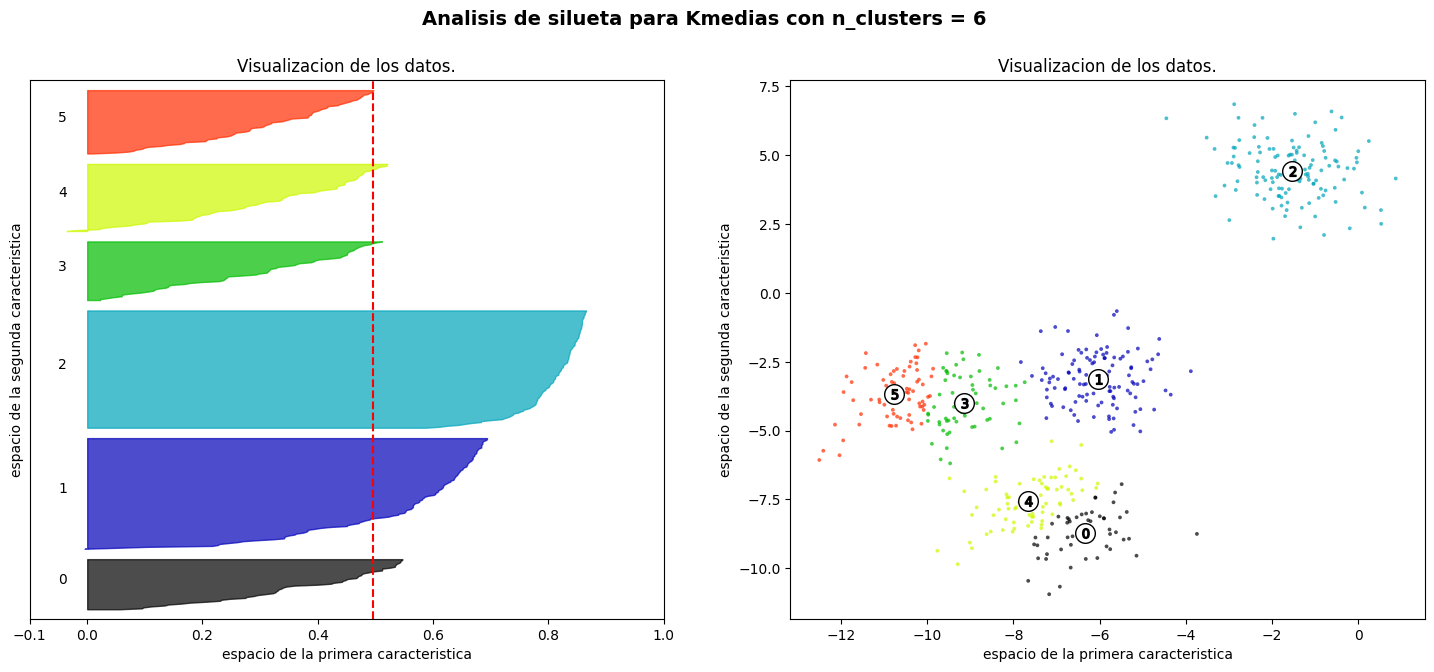

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


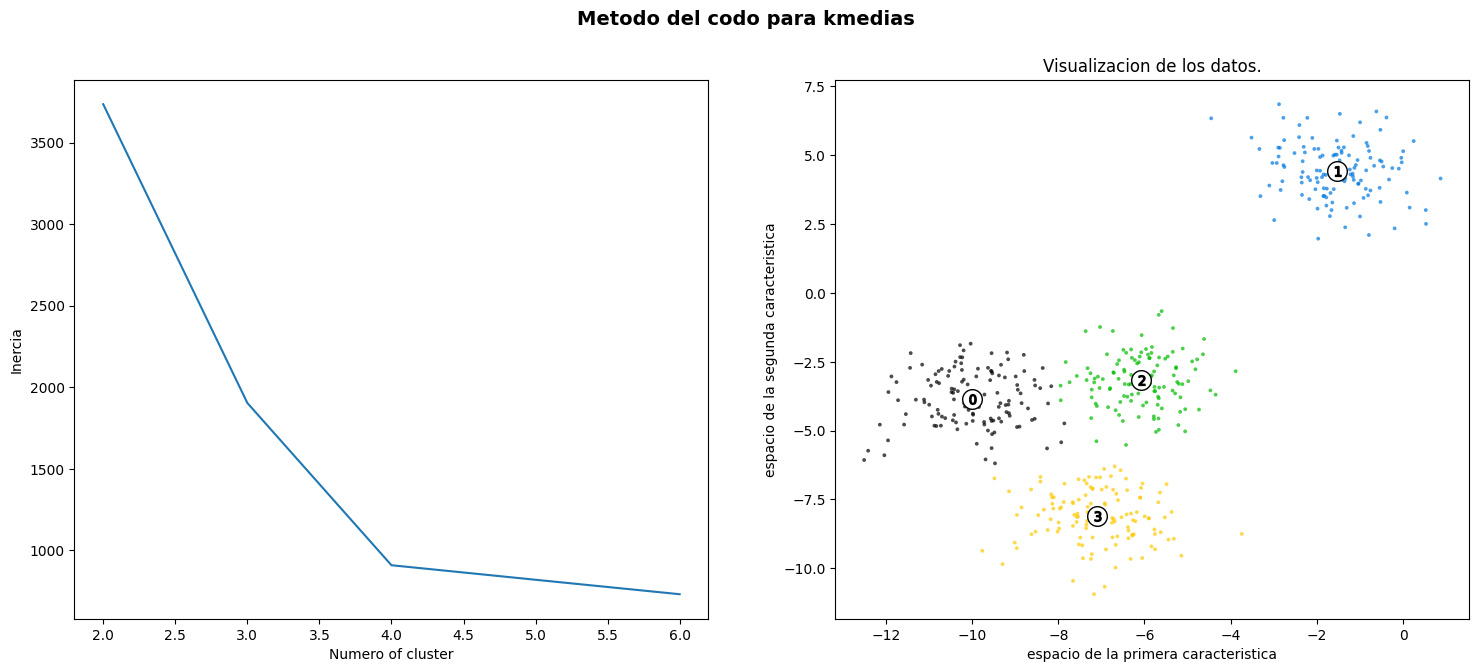

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2,3, 4, 5, 6]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
plt.suptitle(("Metodo del codo para kmedias "),
                 fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Numero of cluster")
ax1.set_ylabel("Inercia")

clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(X)

colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

ax2.set_title("Visualizacion de los datos.")
ax2.set_xlabel("espacio de la primera caracteristica")
ax2.set_ylabel("espacio de la segunda caracteristica")

#plt.savefig("kmeans_elbow", dpi=300)
plt.show()



# DBSCAN clustering

Encuentra muestras core y expande clusters sobre ellas.

Tiene dos parámetros, eps y num of samples. Es muy sensitivo a los parametros

Automatically created module for IPython interactive environment
Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


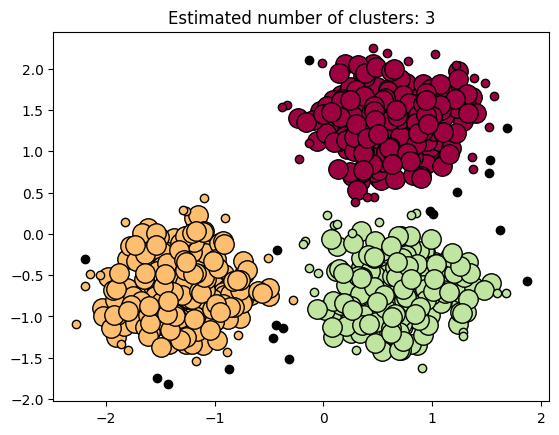

In [ ]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()




# DBSCAN clustering


Encuentra muestras core y expande clusters sobre ellas.

Tiene dos parámetros, eps y num of samples. Es muy sensitivo a los parametros

Para este grupo de datos, repeti el agrupamiento con tres valores de eps, y obtuve un buen agrupamiento en el maximo del caeficiente de silueta.

Es lo que deberia hacer para encontrar un valor razonable de eps.


Automatically created module for IPython interactive environment
Estimated number of clusters: 12
Estimated number of noise points: 518
Homogeneity: 0.310
Completeness: 0.247
V-measure: 0.275
Adjusted Rand Index: 0.022
Adjusted Mutual Information: 0.265
Silhouette Coefficient: -0.365


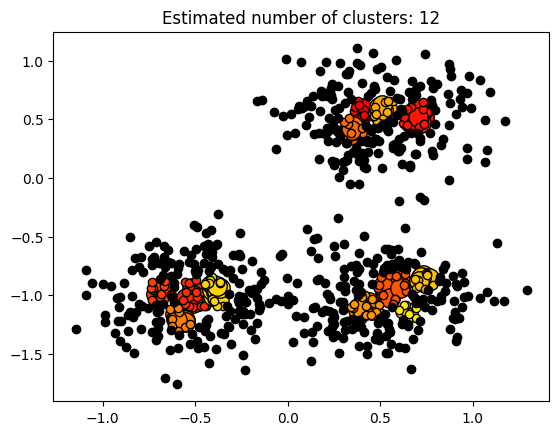

Estimated number of clusters: 3
Estimated number of noise points: 91
Homogeneity: 0.847
Completeness: 0.697
V-measure: 0.765
Adjusted Rand Index: 0.791
Adjusted Mutual Information: 0.764
Silhouette Coefficient: 0.532


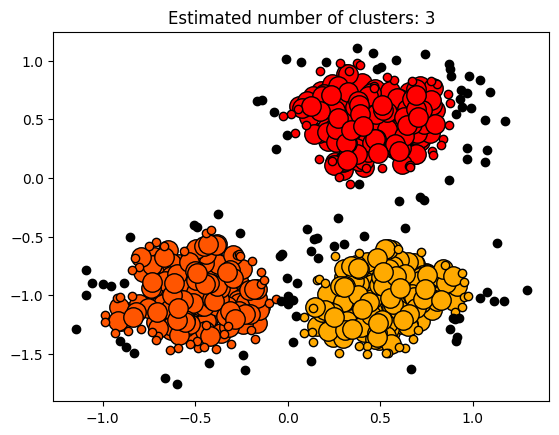

Estimated number of clusters: 2
Estimated number of noise points: 20
Homogeneity: 0.563
Completeness: 0.837
V-measure: 0.673
Adjusted Rand Index: 0.545
Adjusted Mutual Information: 0.672
Silhouette Coefficient: 0.448


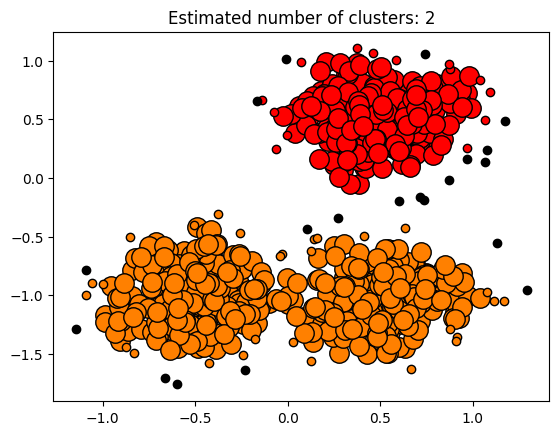

In [ ]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generamos las muestras con poca distancia
#centers = [[1, 1], [-1, -1], [1, -1]]
centers = [[0.5, 0.5], [-0.5, -1], [0.5, -1.0]]
O, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.25,
                            random_state=0)

#escalamos
X = StandardScaler().fit_transform(O)

# #############################################################################
# Compute DBSCAN

#EPS = 0.1
db = DBSCAN(eps=0.1, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = O[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = O[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# #############################################################################
# Compute DBSCAN

#EPS = 0.2
db = DBSCAN(eps=0.2, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = O[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = O[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# #############################################################################
# Compute DBSCAN

#EPS = 0.3
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = O[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = O[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Algoritmo Mean Shift


Reference:

Dorin Comaniciu and Peter Meer, "Mean Shift: A robust approach toward
feature space analysis". IEEE Transactions on Pattern Analysis and
Machine Intelligence. 2002. pp. 603-619.


Automatically created module for IPython interactive environment
Estimated number of clusters: 3
Homogeneity: 0.941
Completeness: 0.941
V-measure: 0.941
Adjusted Rand Index: 0.961
Adjusted Mutual Information: 0.941
Silhouette Coefficient: 0.640


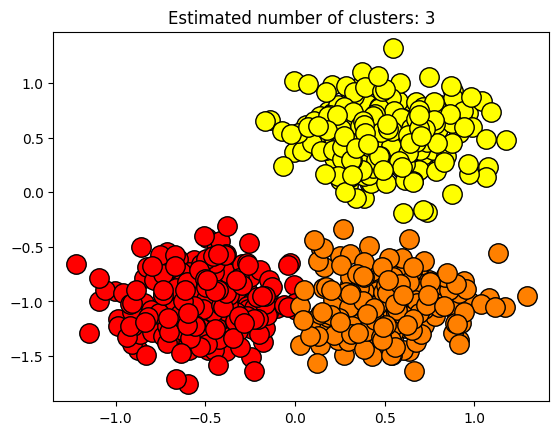

In [ ]:
print(__doc__)

import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# #############################################################################
# Generamos las muestras con poca distancia
#centers = [[1, 1], [-1, -1], [1, -1]]
centers = [[0.5, 0.5], [-0.5, -1], [0.5, -1.0]]
O, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.25,
                            random_state=0)

#escalamos
X = StandardScaler().fit_transform(O)

# #############################################################################
#centers = [[1, 1], [-1, -1], [1, -1]]
#X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    cluster_center = cluster_centers[k]

    xy = O[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)


plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

